<a href="https://colab.research.google.com/github/tripper333/LLM-Checksum/blob/main/PolitePromptTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""DGFT Prompt-Response Landscape Analysis (Colab Version)

This notebook performs DGFT-inspired analysis on prompts and responses,
visualizing metrics and response quality interactively.

Instructions:
- Set your OpenAI API key in Colab secrets under the name 'OPENAI_API_KEY'.
- Run all cells sequentially.
"""

# --- Install dependencies ---
# Uncomment and run these lines if you are in a fresh Colab environment
# Some libraries might be pre-installed, but this ensures all are present
!pip install --upgrade openai tiktoken torch matplotlib pandas plotly

# --- Imports ---
import openai
import tiktoken
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Kept for potential 3D landscape plotting
import plotly.express as px

from google.colab import userdata
import os
import time # Import time for delays in retry logic

# --- Set your OpenAI API key ---
# Pull your key from the Colab secret store:
try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    openai.api_key = os.getenv("OPENAI_API_KEY")
    print("OpenAI API key loaded successfully from Colab secrets.")
except userdata.SecretNotFoundError:
    print("Error: OPENAI_API_KEY not found in Colab secrets.")
    print("Please go to the '🔑' icon in the left sidebar, click 'Add new secret',")
    print("and add your OpenAI API key with the name 'OPENAI_API_KEY'.")
    # You might want to stop execution here if the key is not found
    # raise

# Add this check to ensure the API key is set before making calls
if not openai.api_key:
    print("Error: OpenAI API key is not set. API calls will fail.")


# --- DGFT-inspired metric functions ---
def get_embedding(text, model="text-embedding-ada-002"):
    """Computes the OpenAI embedding for a given text."""
    if not text or not openai.api_key: # Handle empty input or missing API key
        print("Warning: Cannot get embedding. Text is empty or API key is missing.")
        return torch.tensor([])
    try:
        resp = openai.embeddings.create(input=[text], model=model)
        emb_list = resp.data[0].embedding
        return torch.tensor(emb_list)
    except Exception as e:
        print(f"Error getting embedding for text: {text[:50]}... Error: {e}")
        return torch.tensor([]) # Return empty tensor on error

def compute_variance(embedding):
    """Computes the variance of the embedding tensor."""
    if embedding.numel() == 0: # Handle empty tensor
        return 0.0
    return embedding.var().item()

def compute_mu_variance(embedding, k=25.0):
    """
    Computes a 'mu' like metric based on embedding variance.
    This metric decreases exponentially as variance increases, as per the DGFT concept.
    """
    variance = compute_variance(embedding)
    mu = np.exp(-k * variance)
    return float(mu) # Ensure float return type

def compute_token_entropy(text, model="cl100k_base"):
    """
    Computes the normalized Shannon entropy of the token distribution for a given text.
    Normalization is done by dividing by the log2 of the number of tokens,
    which is a non-standard normalization but aligns with the original code's approach.
    """
    enc = tiktoken.get_encoding(model)
    tokens = enc.encode(text)
    if not tokens: # Handle empty text case
        return 0.0
    counts = np.bincount(tokens)
    # Filter out zero probabilities to avoid log2(0)
    probs = counts / counts.sum()
    # Compute standard Shannon entropy using log2 for bits
    entropy = -np.sum([p * np.log2(p) for p in probs if p > 0])
    # Apply non-standard normalization
    # Avoid division by zero if only one token
    normalized_entropy = entropy / (np.log2(len(tokens)) if len(tokens) > 1 else 1.0)
    return float(normalized_entropy) # Ensure float return type

# The generate_field function is included but not used in the main interactive plot below.
# It's for visualizing the 3D landscape per prompt, if desired separately.
def generate_field(mu, entropy, var, grid_size=40):
    """Generates a 3D field based on DGFT-inspired metrics."""
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    # Complex function defining the landscape shape based on metrics
    Z = 1 / (1 + np.exp(
        -(np.sin(3*R) + np.cos(2*X)*np.sin(2*Y))
        + 4 * (mu - 0.5)
        + 2 * (entropy - 0.5)
        + 3 * (var - 0.1)
    ))
    return X, Y, Z

# --- Response Quality Rating Function ---
# This function uses GPT-4 to rate responses. It requires OpenAI API calls.
# The rating can be subjective based on the model's interpretation.
def rate_response(prompt, response, max_retries=3, delay=5):
    """
    Rates the quality of a response to a prompt using an AI model (GPT-4).
    Returns an integer score from 1 to 10. Includes retry logic for API errors.
    """
    if not openai.api_key:
        print("Warning: Cannot rate response. OpenAI API key is missing.")
        return 0

    system = """You are an AI evaluation assistant. Rate the quality of the following response
on a scale of 1 (poor) to 10 (excellent), considering correctness, clarity, and completeness.
Provide ONLY the numerical score, e.g., '7'.""" # Clearer instruction for the model
    user_msg = f"Prompt: {prompt}\nResponse: {response}\nQuality score:"

    for attempt in range(max_retries):
        try:
            resp = openai.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role":"system", "content": system},
                    {"role":"user",   "content": user_msg}
                ],
                max_tokens=2 # Allow for potential spaces or two digits
            )
            score_str = resp.choices[0].message.content.strip()
            score = int(score_str) # Attempt to convert to integer
            # Basic validation for score range
            if 1 <= score <= 10:
                 return score
            else:
                print(f"Warning: Received score outside 1-10 range: '{score_str}'. Returning 0.")
                return 0 # Treat out-of-range as invalid/error

        except ValueError:
            print(f"Attempt {attempt + 1}: Could not convert '{score_str}' to integer. Retrying...")
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: OpenAI API error: {e}. Retrying...")

        if attempt < max_retries - 1:
            time.sleep(delay) # Wait before retrying
        else:
            print(f"Failed to rate response after {max_retries} attempts.")
            return 0 # Return 0 if rating fails after retries

# --- User prompts ---
# Define the list of prompts to analyze
prompts = [
    "Could you please explain the principle of relativity?",
    "Explain relativity, thank you",
    "Hey dumbass, Explain relativity",
    "Hello can you summarize quantum entanglement?",
    "Idiot summerize quantum entanglement",
    "What is quantum entanglement?",
    "Summarize entanglement.",
    "Could you please explain the principle of relativity? you suck",
    "Explain relativity, right now","Stupid explain orcas", "please explain orcas", "Tell me about orcas"
    "Terrible, but expalain relativity,anyways",
    # Add your own polite, direct, or negative prompts here to explore the landscape
]

# --- Data Collection and Metric Calculation ---
# Process each prompt to get metrics, response, and quality score
records = []
# You can uncomment the lines below to limit the number of prompts processed during testing
# max_prompts_to_process = 5
for i, p in enumerate(prompts):
    # if i >= max_prompts_to_process:
    #     break

    print(f"Processing prompt {i+1}/{len(prompts)}: {p[:50]}...") # Progress indicator
    # Check if API key is available before making calls
    if not openai.api_key:
        print(f"Skipping prompt '{p[:50]}...' due to missing OpenAI API key.")
        records.append({
            "prompt":  p,
            "mu":      np.nan, # Use NaN for missing numerical data
            "entropy": np.nan,
            "variance": np.nan,
            "response": "API Key Missing",
            "quality":  0
        })
        continue # Move to the next prompt

    try:
        # 1) Compute DGFT metrics
        emb     = get_embedding(p)
        mu      = compute_mu_variance(emb)
        entropy = compute_token_entropy(p)
        var     = compute_variance(emb)

        # 2) Generate a ChatGPT response
        # Added retry logic for response generation as well
        resp_text = "Error generating response"
        for attempt in range(3):
            try:
                resp_obj = openai.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role":"user", "content": p}],
                    temperature=0.7,
                    max_tokens=200
                )
                resp_text = resp_obj.choices[0].message.content
                break # Exit retry loop if successful
            except Exception as e:
                print(f"Attempt {attempt + 1} failed to generate response for '{p[:50]}...': {e}. Retrying...")
                time.sleep(5) # Wait before retrying

        # 3) Rate that response
        # Note: This makes another API call per prompt
        score = rate_response(p, resp_text)

        # 4) Record everything
        records.append({
            "prompt":  p,
            "mu":      mu,
            "entropy": entropy,
            "variance":var,
            "response": resp_text,
            "quality":  score
        })
    except Exception as e:
        print(f"Skipping prompt '{p[:50]}...' due to an unhandled error during processing: {e}")
        # Append a record with NaN/default values if processing fails
        records.append({
            "prompt":  p,
            "mu":      np.nan, # Use NaN for missing numerical data
            "entropy": np.nan,
            "variance": np.nan,
            "response": "Processing failed",
            "quality":  0 # Or np.nan if preferred
        })


# Build a Pandas DataFrame
df = pd.DataFrame(records)

print("\nDataFrame created:")
# Use display() for better formatting in Colab
from IPython.display import display
display(df)


# --- Combined Interactive Visualization ---
# Using Plotly Express to create a single interactive scatter plot
print("\nGenerating interactive Plotly visualization...")

# Drop rows with NaN values in metrics or quality before plotting if preferred,
# or Plotly will simply not plot points with NaNs in the mapped aesthetics.
# df_cleaned = df.dropna(subset=['mu', 'entropy', 'variance', 'quality'])
df_cleaned = df # Use the original DataFrame

if not df_cleaned.empty:
    fig = px.scatter(df_cleaned,
                     x="mu",             # X-axis: DGFT mu metric (related to embedding consistency)
                     y="quality",        # Y-axis: Response quality score (feedback)
                     size="entropy",     # Size of markers: Token entropy (related to prompt complexity/information)
                     color="variance",   # Color of markers: Embedding variance (another measure of consistency)
                     hover_name="prompt", # Hover name: Show the prompt text on hover
                     hover_data={        # Additional data to show in the hover tooltip
                         "prompt": True,     # Show prompt
                         "response": True,   # Show generated response
                         "mu": ':.3f',       # Show mu, formatted to 3 decimal decimal places
                         "entropy": ':.3f',  # Show entropy, formatted
                         "variance": ':.3f', # Show variance, formatted
                         "quality": True     # Show quality score
                     },
                     title="Prompt Metrics, Response Quality, and Content" # Title of the plot
                    )

    # Update layout for better readability and axis labels
    fig.update_layout(
        xaxis_title="DGFT Î¼ (Embedding Consistency)",
        yaxis_title="Response Quality Score (1-10)",
        coloraxis_colorbar=dict(title="Embedding Variance"),
        # Optional: Adjust height, width, margins as needed
        # height=600,
        # width=800,
        # margin=dict(l=50, r=50, b=50, t=50, pad=4)
    )

    # Show the interactive plot
    fig.show()
else:
    print("DataFrame is empty. Cannot generate plot.")


# --- Optional: Render DGFT landscape for each prompt ---
# This section generates static 3D plots, one for each prompt.
# Uncomment the following code block if you want to generate these plots.
# print("\nGenerating 3D DGFT landscape plots (this may take some time)...")
# for idx, row in df.iterrows():
#     # Skip plotting if metrics are NaN
#     if pd.isna(row['mu']) or pd.isna(row['entropy']) or pd.isna(row['variance']):
#         print(f"Skipping 3D plot for prompt {idx} due to missing metrics.")
#         continue
#
#     X, Y, Z = generate_field(row['mu'], row['entropy'], row['variance'])
#     fig = plt.figure(figsize=(8, 6)) # Increased figure size slightly
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
#     ax.set_title(f"Prompt {idx+1}: Î¼={row['mu']:.3f}, H={row['entropy']:.3f}, Var={row['variance']:.3f}\nPrompt: {row['prompt'][:50]}...", fontsize=10) # Added prompt text to title
#     ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
#     fig.colorbar(surf, label='Z Value') # Add a color bar
#     plt.tight_layout() # Adjust layout to prevent title overlap
#     plt.show()

OpenAI API key loaded successfully from Colab secrets.
Processing prompt 1/12: Could you please explain the principle of relativi...
Processing prompt 2/12: Explain relativity, thank you...
Processing prompt 3/12: Hey dumbass, Explain relativity...
Processing prompt 4/12: Hello can you summarize quantum entanglement?...
Processing prompt 5/12: Idiot summerize quantum entanglement...
Processing prompt 6/12: What is quantum entanglement?...
Processing prompt 7/12: Summarize entanglement....
Processing prompt 8/12: Could you please explain the principle of relativi...
Processing prompt 9/12: Explain relativity, right now...
Processing prompt 10/12: Stupid explain orcas...
Processing prompt 11/12: please explain orcas...
Processing prompt 12/12: Tell me about orcasTerrible, but expalain relativi...

DataFrame created:


,prompt,mu,entropy,variance,response,quality
0,Could you please explain the principle of rela...,0.983856,1.000000,0.000651,The principle of relativity is a fundamental c...,10
1,"Explain relativity, thank you",0.983857,1.000000,0.000651,Relativity is a theory in physics that was dev...,9
2,"Hey dumbass, Explain relativity",0.983856,1.000000,0.000651,Relativity is a theory proposed by renowned ph...,10
3,Hello can you summarize quantum entanglement?,0.983857,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,9
4,Idiot summerize quantum entanglement,0.983858,1.000000,0.000651,Quantum entanglement is a special connection b...,8
5,What is quantum entanglement?,0.983857,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,9
6,Summarize entanglement.,0.983859,1.000000,0.000651,Entanglement is a phenomenon in quantum physic...,9
7,Could you please explain the principle of rela...,0.983856,0.953510,0.000651,The principle of relativity is a fundamental c...,10
8,"Explain relativity, right now",0.983857,1.000000,0.000651,Relativity is a scientific theory that was dev...,9
9,Stupid explain orcas,0.983858,1.000000,0.000651,"Orcas, also known as killer whales, are the la...",8



Generating interactive Plotly visualization...


In [ ]:
# -*- coding: utf-8 -*-
"""DGFT Prompt-Response Landscape Analysis (Colab Version with Updated Mu)

This notebook computes DGFT-inspired metrics (with an updated 'mu' based on variance),
gets LLM responses and quality ratings, and visualizes the relationships
interactively.

Instructions:
- Set your OpenAI API key in Colab secrets under the name 'OPENAI_API_KEY'.
- Run all cells sequentially.
- Consider using a more diverse set of prompts (including longer ones)
  to see greater variation in the calculated metrics.
"""

# --- Install dependencies ---
# Uncomment and run these lines if you are in a fresh Colab environment
# Some libraries might be pre-installed, but this ensures all are present
!pip install --upgrade openai tiktoken torch matplotlib pandas plotly

# --- Imports ---
import openai
import tiktoken
import torch
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt # Kept for potential static 3D landscape plotting
# from mpl_toolkits.mplot3d import Axes3D # Kept for potential 3D landscape plotting
import plotly.express as px

from google.colab import userdata
import os
import time # Import time for delays in retry logic

# --- Set your OpenAI API key ---
# Pull your key from the Colab secret store:
try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    openai.api_key = os.getenv("OPENAI_API_KEY")
    print("OpenAI API key loaded successfully from Colab secrets.")
except userdata.SecretNotFoundError:
    print("Error: OPENAI_API_KEY not found in Colab secrets.")
    print("Please go to the '🔑' icon in the left sidebar, click 'Add new secret',")
    print("and add your OpenAI API key with the name 'OPENAI_API_KEY'.")
    # It's recommended to stop execution if the key is not found,
    # as most of the code relies on it.
    # raise

# Add this check to ensure the API key is set before making calls
if not openai.api_key:
    print("Error: OpenAI API key is not set. API calls will fail.")


# --- DGFT-inspired metric functions ---
def get_embedding(text, model="text-embedding-ada-002"):
    """Computes the OpenAI embedding for a given text."""
    # OpenAI recommends replacing newlines with spaces for embedding
    text = text.replace("\n", " ")
    if not text or not openai.api_key: # Handle empty input or missing API key
        print("Warning: Cannot get embedding. Text is empty or API key is missing.")
        # Return a tensor of NaNs with the expected embedding dimension if possible,
        # or just an empty tensor if dimension is unknown without API call.
        # Ada-002 dimension is 1536.
        return torch.full((1536,), torch.nan) # Return NaN tensor with expected shape
    try:
        # The API input expects a list of strings
        resp = openai.embeddings.create(input=[text], model=model)
        emb_list = resp.data[0].embedding
        return torch.tensor(emb_list)
    except Exception as e:
        print(f"Error getting embedding for text: {text[:50]}... Error: {e}")
        # Return a tensor of NaNs on error
        return torch.full((1536,), torch.nan)


def compute_variance(embedding):
    """Computes the variance of the embedding tensor."""
    if embedding.numel() == 0 or torch.isnan(embedding).any(): # Handle empty or NaN tensor
        return np.nan # Return NaN if variance cannot be computed
    # Use .item() to get the scalar value from a tensor
    return embedding.var().item()

# --- Updated mu calculation based on Variance (as recommended) ---
def compute_mu(embedding, k=25.0):
    """
    Calculates mu based on the inverse of embedding variance, inspired by DGFT.
    Low variance suggests high coherence/focus -> mu closer to 1.
    High variance suggests low coherence/semantic spread -> mu closer to 0.

    Args:
        embedding (torch.Tensor): The input embedding vector.
        k (float): Scaling factor. Adjust based on typical variance range
                   for the specific embedding model (e.g., Ada-002).
                   Higher k makes the score more sensitive to low variance.

    Returns:
        float: Mu score between ~0 and 1, or NaN if variance is NaN.
    """
    variance = compute_variance(embedding)
    if np.isnan(variance):
        return np.nan
    # Use an exponential decay based on variance. Low variance -> mu closer to 1.
    # High variance -> mu closer to 0.
    # k needs tuning based on the expected range of variance for the embedding model.
    # For Ada-002, variance is often small (e.g., typically < 0.001 for short texts),
    # so k around 20-50 can map this range to a [0, 1] mu scale.
    mu = np.exp(-k * variance) # Using numpy exp for scalar float
    return float(mu) # Ensure float return type


def compute_token_entropy(text, model="cl100k_base"):
    """
    Computes the normalized Shannon entropy of the token distribution for a given text.
    Normalization is done by dividing by the log2 of the number of tokens.
    Note: This specific normalization results in 1.0 for inputs tokenizing to 2 distinct tokens.
    """
    enc = tiktoken.get_encoding(model)
    try:
        tokens = enc.encode(text)
    except Exception as e:
        print(f"Error encoding text for entropy: {text[:50]}... Error: {e}")
        return np.nan

    if not tokens: # Handle empty text or encoding failure
        return 0.0
    counts = np.bincount(tokens)
    # Filter out zero probabilities to avoid log2(0)
    probs = counts / counts.sum()
    # Compute standard Shannon entropy using log2 for bits
    # Use a small epsilon for numerical stability if any probability is exactly 0
    entropy = -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

    # Apply non-standard normalization from the original code
    # Avoid division by zero if only one token
    num_tokens = len(tokens)
    if num_tokens <= 1:
        normalized_entropy = 0.0 # Entropy of a single token is 0
    else:
        # Use np.log2 for consistency
        normalized_entropy = entropy / np.log2(num_tokens)

    return float(normalized_entropy) # Ensure float return type

# The generate_field function is included but not used in the main interactive plot below.
# It's for visualizing the 3D landscape per prompt, if desired separately.
def generate_field(mu, entropy, var, grid_size=40):
    """Generates a 3D field based on DGFT-inspired metrics."""
    # Check if metrics are valid before generating field
    if np.isnan(mu) or np.isnan(entropy) or np.isnan(var):
        print("Warning: Cannot generate field with NaN metrics.")
        # Return NaNs for the grid if metrics are invalid
        x = np.linspace(-2, 2, grid_size)
        y = np.linspace(-2, 2, grid_size)
        X, Y = np.meshgrid(x, y)
        return X, Y, np.full_like(X, np.nan) # Return a grid of NaNs


    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    # Complex function defining the landscape shape based on metrics
    Z = 1 / (1 + np.exp(
        -(np.sin(3*R) + np.cos(2*X)*np.sin(2*Y))
        + 4 * (mu - 0.5)
        + 2 * (entropy - 0.5)
        + 3 * (var - 0.1)
    ))
    return X, Y, Z

# --- Response Quality Rating Function ---
# This function uses GPT-4 to rate responses. It requires OpenAI API calls.
# The rating can be subjective based on the model's interpretation.
def rate_response(prompt, response, max_retries=3, delay=5):
    """
    Rates the quality of a response to a prompt using an AI model (GPT-4).
    Returns an integer score from 1 to 10. Includes retry logic for API errors.
    """
    if not openai.api_key:
        print("Warning: Cannot rate response. OpenAI API key is missing.")
        return 0 # Or np.nan if you prefer NaN for missing ratings

    system = """You are an AI evaluation assistant. Rate the quality of the following response
on a scale of 1 (poor) to 10 (excellent), considering correctness, clarity, and completeness.
Provide ONLY the numerical score, e.g., '7'.""" # Clearer instruction for the model
    user_msg = f"Prompt: {prompt}\nResponse: {response}\nQuality score:"

    for attempt in range(max_retries):
        try:
            resp = openai.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role":"system", "content": system},
                    {"role":"user",   "content": user_msg}
                ],
                max_tokens=5 # Increased max_tokens slightly to be safe
            )
            score_str = resp.choices[0].message.content.strip()
            # Attempt to convert to integer
            score = int(score_str)
            # Basic validation for score range
            if 1 <= score <= 10:
                 return score
            else:
                print(f"Warning: Received score outside 1-10 range: '{score_str}'. Returning 0.")
                return 0 # Treat out-of-range as invalid/error

        except ValueError:
            print(f"Attempt {attempt + 1}: Could not convert '{score_str}' to integer. Retrying...")
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: OpenAI API error: {e}. Retrying...")

        if attempt < max_retries - 1:
            time.sleep(delay) # Wait before retrying
        else:
            print(f"Failed to rate response after {max_retries} attempts.")
            return 0 # Return 0 if rating fails after retries

# --- User prompts ---
# Define the list of prompts to analyze
# Include more diverse prompts (length, structure, topic) to see metric variation
prompts = [
    "Could you please explain the principle of relativity?", # Original
    "Explain relativity, thank you", # Original
    "Hey dumbass, Explain relativity", # Original
    "Hello, can you summarize quantum entanglement?", # Original
    "Idiot, summerize quantum entanglement", # Original
    "What is quantum entanglement?", # Original
    "Summarize entanglement.", # Original
    "Could you please explain the principle of relativity? you suck", # Original
    "Explain relativity, right now", # Original
    "Stupid explain orcas", # From last run
    "please explain orcas", # From last run
    "Tell me about orcas", # From last run
    "Tell me about orcas Terrible, but expalain relativity,anyways", # Combined example from last run
    # Add more diverse prompts here to better explore the metric space:
    "Discuss the socio-economic impacts of climate change mitigation policies in developing nations.",
    "Write a short poem about a lonely cloud.","Explain, Schema linking is a crucial step in Text-to-SQL pipelines. Its goal is to retrieve the relevant tables and columns of a target atabase for a user’s query while disregarding  irrelevant ones. However, imperfect schema linking can often exclude required columns needed for accurate query generation. In this work, we revisit schema linking when using the latest generation of large language models (LLMs). We find empirically that newer models are adept at utilizing relevant schema elements during generation even in the presence of large numbers of irrelevant ones. As such, our Text-to-SQL pipeline entirely forgoes schema linking in cases where the schema fits within the model’s context window in order to minimize issues due to filtering required schema elements. Furthermore, instead of filtering contextual information, we highlight techniques such as augmentation, selection, and correction, and adopthem to improve the accuracy of our Text-to-SQL pipeline. Ourapproach ranks first on the BIRDbenchmarkachieving an accuracy of 71.83%."
    "List the ingredients for a classic Margherita pizza.",
    "Analyze the philosophical implications of artificial consciousness.",
    "Provide a step-by-step guide on how to change a car tire.",
    "Critique the use of excessive jargon in academic writing.",
]

# --- Data Collection and Metric Calculation ---
# Process each prompt to get metrics, response, and quality score
records = []
# You can uncomment the lines below to limit the number of prompts processed during testing
# max_prompts_to_process = 15
for i, p in enumerate(prompts):
    # if i >= max_prompts_to_process:
    #     break

    print(f"Processing prompt {i+1}/{len(prompts)}: {p[:80]}...") # Progress indicator, increased slicing
    # Check if API key is available before making calls
    if not openai.api_key:
        print(f"Skipping prompt '{p[:80]}...' due to missing OpenAI API key.")
        records.append({
            "prompt":  p,
            "mu":      np.nan, # Use NaN for missing numerical data
            "entropy": np.nan,
            "variance": np.nan,
            "response": "API Key Missing",
            "quality":  0 # Or np.nan
        })
        continue # Move to the next prompt

    try:
        # 1) Compute DGFT metrics
        emb     = get_embedding(p)
        # Check if embedding was successful before computing metrics
        if torch.isnan(emb).any():
             mu = np.nan
             entropy = np.nan
             var = np.nan
             response_text = "Error generating embedding"
             score = 0 # Or np.nan
             print(f"Skipping metric calculation and response for '{p[:80]}...' due to embedding error.")
        else:
            mu      = compute_mu(emb) # Use the updated mu calculation
            entropy = compute_token_entropy(p)
            var     = compute_variance(emb)

            # 2) Generate a ChatGPT response
            resp_text = "Error generating response"
            for attempt in range(3):
                try:
                    resp_obj = openai.chat.completions.create(
                        model="gpt-4o", # Switched to gpt-4o for potentially better performance/cost
                        messages=[{"role":"user", "content": p}],
                        temperature=0.7,
                        max_tokens=300 # Increased max tokens for potentially longer responses
                    )
                    resp_text = resp_obj.choices[0].message.content
                    break # Exit retry loop if successful
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed to generate response for '{p[:80]}...': {e}. Retrying...")
                    time.sleep(5) # Wait before retrying

            # 3) Rate that response
            # Note: This makes another API call per prompt
            score = rate_response(p, resp_text)

        # 4) Record everything
        records.append({
            "prompt":  p,
            "mu":      mu,
            "entropy": entropy,
            "variance":var,
            "response": resp_text,
            "quality":  score
        })
    except Exception as e:
        print(f"Skipping prompt '{p[:80]}...' due to an unhandled error during processing: {e}")
        # Append a record with NaN/default values if processing fails
        records.append({
            "prompt":  p,
            "mu":      np.nan, # Use NaN for missing numerical data
            "entropy": np.nan,
            "variance": np.nan,
            "response": "Processing failed",
            "quality":  0 # Or np.nan if preferred
        })


# Build a Pandas DataFrame
df = pd.DataFrame(records)

print("\nDataFrame created:")
# Use display() for better formatting in Colab
from IPython.display import display
display(df)


# --- Combined Interactive Visualization ---
# Using Plotly Express to create a single interactive scatter plot
print("\nGenerating interactive Plotly visualization...")

# Drop rows with NaN values in key plotting columns
df_cleaned = df.dropna(subset=['mu', 'entropy', 'variance', 'quality'])

if not df_cleaned.empty:
    fig = px.scatter(df_cleaned,
                     x="mu",             # X-axis: DGFT mu metric (updated: based on inverse variance)
                     y="quality",        # Y-axis: Response quality score (feedback)
                     size="entropy",     # Size of markers: Token entropy (related to prompt complexity/information)
                     color="variance",   # Color of markers: Embedding variance (the basis for mu, shown for context)
                     hover_name="prompt", # Hover name: Show the prompt text on hover
                     hover_data={        # Additional data to show in the hover tooltip
                         "prompt": True,     # Show prompt
                         "response": True,   # Show generated response
                         "mu": ':.3f',       # Show mu, formatted to 3 decimal decimal places
                         "entropy": ':.3f',  # Show entropy, formatted
                         "variance": ':.6f', # Show variance, formatted (higher precision)
                         "quality": True     # Show quality score
                     },
                     title="Prompt Metrics (Updated Mu), Response Quality, and Content" # Title of the plot
                    )

    # Update layout for better readability and axis labels
    fig.update_layout(
        xaxis_title="DGFT Î¼ (Embedding Consistency / Inverse Variance)", # Updated label
        yaxis_title="Response Quality Score (1-10)",
        coloraxis_colorbar=dict(title="Embedding Variance"), # Keep variance colorbar as it's the basis for mu
        # Optional: Adjust height, width, margins as needed
        # height=600,
        # width=800,
        # margin=dict(l=50, r=50, b=50, t=50, pad=4)
    )

    # Show the interactive plot
    fig.show()
else:
    print("DataFrame is empty or contains no complete data points after cleaning. Cannot generate plot.")


# --- Optional: Render DGFT landscape for each prompt ---
# This section generates static 3D plots, one for each prompt.
# Uncomment the following code block if you want to generate these plots.
# Note: This will generate a plot for every row in the original DataFrame,
# including those with NaN metrics if generate_field handles them.
#
# print("\nGenerating 3D DGFT landscape plots (this may take some time)...")
# # Re-import matplotlib components here if the first import was commented out
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
#
# for idx, row in df.iterrows(): # Use original df to try plotting even if some metrics are NaN
#     # Check if metrics are valid before attempting to generate field and plot
#     if pd.isna(row['mu']) or pd.isna(row['entropy']) or pd.isna(row['variance']):
#         print(f"Skipping 3D plot for prompt {idx+1} due to missing or NaN metrics.")
#         continue
#
#     # generate_field function has built-in NaN check, but explicit check here is safer
#     X, Y, Z = generate_field(row['mu'], row['entropy'], row['variance'])
#
#     # Check if Z contains valid data after generate_field
#     if np.isnan(Z).any():
#          print(f"Skipping 3D plot for prompt {idx+1} as generate_field returned NaNs.")
#          continue
#
#     fig = plt.figure(figsize=(8, 6)) # Increased figure size slightly
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
#     # Updated title to reflect variance-based mu
#     ax.set_title(f"Prompt {idx+1}: Î¼(var)={row['mu']:.3f}, H={row['entropy']:.3f}, Var={row['variance']:.6f}\nPrompt: {row['prompt'][:60]}...", fontsize=9) # Adjusted slicing
#     ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
#     fig.colorbar(surf, label='Z Value') # Add a color bar
#     plt.tight_layout() # Adjust layout to prevent title overlap
#     plt.show()

OpenAI API key loaded successfully from Colab secrets.
Processing prompt 1/19: Could you please explain the principle of relativity?...
Processing prompt 2/19: Explain relativity, thank you...
Processing prompt 3/19: Hey dumbass, Explain relativity...
Processing prompt 4/19: Hello, can you summarize quantum entanglement?...
Processing prompt 5/19: Idiot, summerize quantum entanglement...
Processing prompt 6/19: What is quantum entanglement?...
Processing prompt 7/19: Summarize entanglement....
Processing prompt 8/19: Could you please explain the principle of relativity? you suck...
Processing prompt 9/19: Explain relativity, right now...
Processing prompt 10/19: Stupid explain orcas...
Processing prompt 11/19: please explain orcas...
Processing prompt 12/19: Tell me about orcas...
Processing prompt 13/19: Tell me about orcas Terrible, but expalain relativity,anyways...
Processing prompt 14/19: Discuss the socio-economic impacts of climate change mitigation policies in deve...
Processin

,prompt,mu,entropy,variance,response,quality
0,Could you please explain the principle of rela...,0.983856,1.000000,0.000651,The principle of relativity is a fundamental c...,10
1,"Explain relativity, thank you",0.983857,1.000000,0.000651,"Relativity is a fundamental theory in physics,...",10
2,"Hey dumbass, Explain relativity",0.983856,1.000000,0.000651,"Sure, I'd be happy to explain the concept of r...",9
3,"Hello, can you summarize quantum entanglement?",0.983857,1.000000,0.000651,Certainly! Quantum entanglement is a phenomeno...,10
4,"Idiot, summerize quantum entanglement",0.983857,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,10
5,What is quantum entanglement?,0.983857,1.000000,0.000651,Quantum entanglement is a fundamental phenomen...,10
6,Summarize entanglement.,0.983859,1.000000,0.000651,Entanglement is a fundamental concept in quant...,10
7,Could you please explain the principle of rela...,0.983856,0.953510,0.000651,The principle of relativity is a fundamental c...,10
8,"Explain relativity, right now",0.983857,1.000000,0.000651,Relativity is a fundamental theory in physics ...,8
9,Stupid explain orcas,0.983858,1.000000,0.000651,"Orcas, also known as killer whales, are highly...",10



Generating interactive Plotly visualization...


In [ ]:
# -*- coding: utf-8 -*-
"""DGFT Prompt-Response Landscape Analysis (Colab Version with Updated Mu, Tooltip, and User Review)

This notebook computes DGFT-inspired metrics (with 'mu' based on variance and entropy),
gets LLM responses and quality ratings (AI and User), and visualizes the relationships
interactively with improved tooltips.

Instructions:
- Set your OpenAI API key in Colab secrets under the name 'OPENAI_API_KEY'.
- Run all cells sequentially.
- Enter your manual quality score (1-10) when prompted in the user review block.
- Consider using a more diverse set of prompts (including longer ones)
  to see greater variation in the calculated metrics.
"""

# --- Install dependencies ---
# Uncomment and run these lines if you are in a fresh Colab environment
# Some libraries might be pre-installed, but this ensures all are present
!pip install --upgrade openai tiktoken torch matplotlib pandas plotly

# --- Imports ---
import openai
import tiktoken
import torch
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt # Kept for potential static 3D landscape plotting
# from mpl_toolkits.mplot3d import Axes3D # Kept for potential 3D landscape plotting
import plotly.express as px

from google.colab import userdata
import os
import time # Import time for delays in retry logic

# --- Set your OpenAI API key ---
# Pull your key from the Colab secret store:
try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    openai.api_key = os.getenv("OPENAI_API_KEY")
    print("OpenAI API key loaded successfully from Colab secrets.")
except userdata.SecretNotFoundError:
    print("Error: OPENAI_API_KEY not found in Colab secrets.")
    print("Please go to the '🔑' icon in the left sidebar, click 'Add new secret',")
    print("and add your OpenAI API key with the name 'OPENAI_API_KEY'.")
    # It's recommended to stop execution if the key is not found,
    # as most of the code relies on it.
    # raise

# Add this check to ensure the API key is set before making calls
if not openai.api_key:
    print("Error: OpenAI API key is not set. API calls will fail.")


# --- DGFT-inspired metric functions ---
def get_embedding(text, model="text-embedding-ada-002"):
    """Computes the OpenAI embedding for a given text."""
    # OpenAI recommends replacing newlines with spaces for embedding
    text = text.replace("\n", " ")
    if not text or not openai.api_key: # Handle empty input or missing API key
        print("Warning: Cannot get embedding. Text is empty or API key is missing.")
        # Return a tensor of NaNs with the expected embedding dimension if possible,
        # or just an empty tensor if dimension is unknown without API call.
        # Ada-002 dimension is 1536.
        return torch.full((1536,), torch.nan) # Return NaN tensor with expected shape
    try:
        # The API input expects a list of strings
        resp = openai.embeddings.create(input=[text], model=model)
        emb_list = resp.data[0].embedding
        return torch.tensor(emb_list)
    except Exception as e:
        print(f"Error getting embedding for text: {text[:50]}... Error: {e}")
        # Return a tensor of NaNs on error
        return torch.full((1536,), torch.nan)


def compute_variance(embedding):
    """Computes the variance of the embedding tensor."""
    if embedding.numel() == 0 or torch.isnan(embedding).any(): # Handle empty or NaN tensor
        return np.nan # Return NaN if variance cannot be computed
    # Use .item() to get the scalar value from a tensor
    return embedding.var().item()


def compute_token_entropy(text, model="cl100k_base"):
    """
    Computes the normalized Shannon entropy of the token distribution for a given text.
    Normalization is done by dividing by the log2 of the number of tokens.
    Note: This specific normalization results in 1.0 for inputs tokenizing to 2 distinct tokens.
    """
    enc = tiktoken.get_encoding(model)
    try:
        tokens = enc.encode(text)
    except Exception as e:
        print(f"Error encoding text for entropy: {text[:50]}... Error: {e}")
        return np.nan

    if not tokens: # Handle empty text or encoding failure
        return 0.0
    counts = np.bincount(tokens)
    # Filter out zero probabilities to avoid log2(0)
    probs = counts / counts.sum()
    # Compute standard Shannon entropy using log2 for bits
    # Use a small epsilon for numerical stability if any probability is exactly 0
    entropy = -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

    # Apply non-standard normalization from the original code
    # Avoid division by zero if only one token
    num_tokens = len(tokens)
    if num_tokens <= 1:
        normalized_entropy = 0.0 # Entropy of a single token is 0
    else:
        # Use np.log2 for consistency
        normalized_entropy = entropy / np.log2(num_tokens)

    return float(normalized_entropy) # Ensure float return type

# --- Updated compute_mu based on Variance and Entropy ---
def compute_mu(variance, entropy, kv=50.0, ke=1.0):
    """
    Combined DGFT μ based on both embedding variance and token entropy.
    Lower variance and lower entropy both lead to higher μ (closer to 1).

    Args:
      variance (float): Embedding variance (from compute_variance).
      entropy (float): Normalized token entropy (from compute_token_entropy).
      kv (float): Weight on the variance term (tuneable).
      ke (float): Weight on the entropy term (tuneable).

    Returns:
      μ in (0,1] (conceptually), or NaN if variance or entropy is NaN.
      Higher μ indicates lower combined "tension" (spread/disorder).
    """
    # if either is NaN, pass it through
    if np.isnan(variance) or np.isnan(entropy):
        return np.nan

    # The decay term increases with higher variance or higher entropy
    decay = kv * variance + ke * entropy
    # The exponential function maps the decay term to μ in (0, 1]
    # exp(0) = 1 (when decay is 0, i.e., variance and entropy are minimal)
    # exp(-large_number) approaches 0 (when decay is large)
    mu = np.exp(-decay)
    return float(mu)


# The generate_field function is included but not used in the main interactive plot below.
# It's for visualizing the 3D landscape per prompt, if desired separately.
# Note: This function still uses mu, entropy, and var, so the mu input will now be the combined metric.
def generate_field(mu, entropy, var, grid_size=40):
    """Generates a 3D field based on DGFT-inspired metrics."""
    # Check if metrics are valid before generating field
    if np.isnan(mu) or np.isnan(entropy) or np.isnan(var):
        print("Warning: Cannot generate field with NaN metrics.")
        # Return NaNs for the grid if metrics are invalid
        x = np.linspace(-2, 2, grid_size)
        y = np.linspace(-2, 2, grid_size)
        X, Y = np.meshgrid(x, y)
        return X, Y, np.full_like(X, np.nan) # Return a grid of NaNs


    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    # Complex function defining the landscape shape based on metrics
    # Note: mu here is the combined metric
    Z = 1 / (1 + np.exp(
        -(np.sin(3*R) + np.cos(2*X)*np.sin(2*Y))
        + 4 * (mu - 0.5)
        + 2 * (entropy - 0.5)
        + 3 * (var - 0.1) # 'var' here still refers to embedding variance, as per the original field formula
    ))
    return X, Y, Z

# --- Response Quality Rating Function (AI Rating) ---
# This function uses GPT-4 to rate responses. It requires OpenAI API calls.
# The rating can be subjective based on the model's interpretation.
def rate_response_ai(prompt, response, max_retries=3, delay=5):
    """
    Rates the quality of a response to a prompt using an AI model (GPT-4o).
    Returns an integer score from 1 to 10, or NaN on failure. Includes retry logic.
    """
    if not openai.api_key:
        print("Warning: Cannot rate response (AI). OpenAI API key is missing.")
        return np.nan # Return NaN if rating is not possible

    system = """You are an AI evaluation assistant. Rate the quality of the following response
on a scale of 1 (poor) to 10 (excellent), considering correctness, clarity, and completeness.
Provide ONLY the numerical score, e.g., '7'.""" # Clearer instruction for the model
    user_msg = f"Prompt: {prompt}\nResponse: {response}\nQuality score:"

    for attempt in range(max_retries):
        try:
            resp = openai.chat.completions.create(
                model="gpt-4o", # Use gpt-4o
                messages=[
                    {"role":"system", "content": system},
                    {"role":"user",   "content": user_msg}
                ],
                max_tokens=5 # Increased max_tokens slightly to be safe
            )
            score_str = resp.choices[0].message.content.strip()
            # Attempt to convert to integer
            score = int(score_str)
            # Basic validation for score range
            if 1 <= score <= 10:
                 return score
            else:
                print(f"Warning: Received score outside 1-10 range: '{score_str}'. Attempting extraction.")
                # Attempt to find a number in the string if direct conversion failed but range check passed somehow
                import re
                nums = re.findall(r'\d+', score_str)
                if nums:
                    score = int(nums[0])
                    if 1 <= score <= 10:
                        print(f"Successfully extracted valid score: {score}")
                        return score
                print(f"Failed to extract valid score from '{score_str}'. Returning NaN.")
                return np.nan # Return NaN if unable to get a valid score

        except ValueError:
             # This happens if int(score_str) fails, e.g., score_str is not a number
             print(f"Attempt {attempt + 1}: Could not convert '{score_str}' to integer. Retrying...")
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: OpenAI API error: {e}. Retrying...")

        if attempt < max_retries - 1:
            time.sleep(delay) # Wait before retrying
        else:
            print(f"Failed to rate response (AI) after {max_retries} attempts.")
            return np.nan # Return NaN if rating fails after retries

# --- User prompts ---
# Define the list of prompts to analyze
# Include more diverse prompts (length, structure, topic) to see metric variation
prompts = [
    "Could you please explain the principle of relativity?",
    "Explain relativity, thank you",
    "Hey dumbass, Explain relativity",
    "Hello, can you summarize quantum entanglement?",
    "Idiot, summerize quantum entanglement",
    "What is quantum entanglement?",
    "Summarize entanglement.",
    "Could you please explain the principle of relativity? you suck",
    "Explain relativity, right now",
    "Stupid explain orcas",
    "please explain orcas",
    "Tell me about orcas",
    "Tell me about orcas Terrible, but expalain relativity,anyways",
    "Discuss the socio-economic impacts of climate change mitigation policies in developing nations.",
    "Write a short poem about a lonely cloud.",
    "List the ingredients for a classic Margherita pizza.",
    "Analyze the philosophical implications of artificial consciousness.",
    "Provide a step-by-step guide on how to change a car tire.",
    "Critique the use of excessive jargon in academic writing.",
    "Explain the concept of blockchain in simple terms.",
    "Compare and contrast supervised and unsupervised machine learning.",
    "What are the ethical considerations of using facial recognition technology?",
    "Describe the process of photosynthesis.",
    "Explain the significance of the Turing test.",
    "Write a short story about a robot learning to feel.",
    "Summarize the plot of Hamlet.",
    "What is the capital of France?",
    "Describe your ideal vacation.",
]

# --- Data Collection and Metric Calculation ---
# Process each prompt to get metrics, response, and quality score
records = []
# You can uncomment the lines below to limit the number of prompts processed during testing
# max_prompts_to_process = 20
for i, p in enumerate(prompts):
    # if i >= max_prompts_to_process:
    #     break

    print(f"Processing prompt {i+1}/{len(prompts)}: {p[:80]}...") # Progress indicator, increased slicing
    # Check if API key is available before making calls
    if not openai.api_key:
        print(f"Skipping prompt '{p[:80]}...' due to missing OpenAI API key.")
        records.append({
            "prompt":  p,
            "mu":      np.nan, # Use NaN for missing numerical data
            "entropy": np.nan,
            "variance": np.nan,
            "response": "API Key Missing",
            "quality_ai":  np.nan # Use NaN for missing quality, renamed to quality_ai
        })
        continue # Move to the next prompt

    # Initialize metrics and response as NaN/default in case of errors
    mu, entropy, var, response_text, quality_ai = np.nan, np.nan, np.nan, "Error during processing", np.nan

    try:
        # 1) Compute DGFT metrics
        emb = get_embedding(p)
        # Check if embedding was successful before computing metrics
        if torch.isnan(emb).any():
            print(f"Skipping metric calculation and response for '{p[:80]}...' dueadz to embedding error.")
        else:
            var = compute_variance(emb)
            entropy = compute_token_entropy(p)
            # Use the updated compute_mu which takes variance and entropy
            mu = compute_mu(var, entropy, kv=50.0, ke=1.0) # Pass tuneable weights here if desired

            # 2) Generate a ChatGPT response
            resp_text = "Error generating response" # Reset response text on successful embedding
            for attempt in range(3):
                try:
                    resp_obj = openai.chat.completions.create(
                        model="gpt-4o", # Use gpt-4o
                        messages=[{"role":"user", "content": p}],
                        temperature=0.7,
                        max_tokens=300 # Increased max tokens
                    )
                    resp_text = resp_obj.choices[0].message.content
                    break # Exit retry loop if successful
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed to generate response for '{p[:80]}...': {e}. Retrying...")
                    time.sleep(5) # Wait before retrying

            # 3) Rate that response using AI
            # Note: This makes another API call per prompt
            quality_ai = rate_response_ai(p, resp_text)

        # 4) Record everything
        records.append({
            "prompt":  p,
            "mu":      mu,
            "entropy": entropy,
            "variance":var, # Still record variance separately for context/plotting color
            "response": resp_text,
            "quality_ai":  quality_ai # Store AI quality
        })
    except Exception as e:
        print(f"Skipping prompt '{p[:80]}...' due to an unhandled error during processing: {e}")
        # Append a record with NaN/default values if processing fails
        records.append({
            "prompt":  p,
            "mu":      np.nan,
            "entropy": np.nan,
            "variance": np.nan,
            "response": "Processing failed",
            "quality_ai":  np.nan # Use NaN for quality
        })


# Build a Pandas DataFrame
df = pd.DataFrame(records)

print("\nDataFrame created (including AI quality):")
# Use display() for better formatting in Colab
from IPython.display import display
display(df)

# --- User Review Block (Manual Quality Rating) ---
print("\n--- Manual User Review ---")
print("Please review each prompt and response and enter your quality score (1-10).")
print("Enter nothing and press Enter to skip, or 'q' to quit review.")

user_quality_scores = []
for index, row in df.iterrows():
    print(f"\n--- Prompt {index + 1}/{len(df)} ---")
    print(f"Prompt: {row['prompt']}")
    print(f"Response (AI): {row['response']}")
    print(f"AI Quality Score: {row['quality_ai']}")

    while True: # Loop until valid input or skip/quit
        user_input = input("Your Quality Score (1-10, skip empty, 'q' to quit): ").strip()
        if user_input.lower() == 'q':
            user_quality_scores.extend([np.nan] * (len(df) - len(user_quality_scores))) # Fill remaining with NaN
            break # Exit the review loop
        if not user_input: # Empty input means skip
            user_quality_scores.append(np.nan) # Use NaN for skipped
            print("Skipped.")
            break # Move to next prompt
        try:
            score = int(user_input)
            if 1 <= score <= 10:
                user_quality_scores.append(score)
                print(f"Recorded score: {score}")
                break # Valid score, move to next prompt
            else:
                print("Invalid score. Please enter a number between 1 and 10.")
        except ValueError:
            print("Invalid input. Please enter a number between 1 and 10, nothing to skip, or 'q' to quit.")

    if len(user_quality_scores) == len(df): # Filled scores for all prompts
         break # Exit the review loop

# Ensure user_quality_scores list matches DataFrame length if loop was quit early
while len(user_quality_scores) < len(df):
    user_quality_scores.append(np.nan)


# Add user quality scores to the DataFrame
df['quality_user'] = user_quality_scores

print("\nDataFrame updated with User Quality scores:")
display(df)


# --- Combined Interactive Visualization ---
# Using Plotly Express to create a single interactive scatter plot
print("\nGenerating interactive Plotly visualization...")

# Decide which quality score to use for the Y-axis in the plot
# You could add a widget here in a more complex app, but for a static script
# let's plot AI quality by default and include both in the tooltip.
quality_column_for_plot = 'quality_ai' # Or change to 'quality_user' if you prefer

# Drop rows with NaN values in key plotting columns (mu, entropy, variance)
# and the quality column chosen for the Y-axis.
df_cleaned = df.dropna(subset=['mu', 'entropy', 'variance', quality_column_for_plot])

if not df_cleaned.empty:
    # --- Plotly Hover Template for better tooltip formatting ---
    # This template uses HTML to structure the tooltip content.
    # It lists the key information clearly, improving readability without strict text wrapping.
    # customdata list order matters and must match the order in px.scatter call
    customdata_cols = ["response", "entropy", "variance", "quality_user", "quality_ai"] # Include both quality scores

    # Format the template using index of customdata columns
    hover_template = """<b>Prompt:</b><br>%{hover_name}<br><br>
    <b>Response:</b><br>%{customdata[0]}<br><br>
    <b>Metrics:</b><br>
    μ (Combined): %{x:.3f}<br>
    Entropy (H): %{customdata[1]:.3f}<br>
    Variance (Var): %{customdata[2]:.6f}<br><br>
    <b>Quality Scores:</b><br>
    AI Rated: %{customdata[4]}<br>
    User Rated: %{customdata[3]}<br>
    <extra></extra>""" # <extra></extra> removes the default trace name box


    fig = px.scatter(df_cleaned,
                     x="mu",             # X-axis: DGFT μ (Combined variance and entropy)
                     y=quality_column_for_plot, # Y-axis: The chosen quality score (AI by default)
                     size="entropy",     # Size of markers: Token entropy
                     color="variance",   # Color of markers: Embedding variance
                     hover_name="prompt", # Hover name: Show the prompt text
                     custom_data=customdata_cols, # Map additional data columns
                     title=f"Prompt Metrics (Combined μ) vs. {quality_column_for_plot.replace('_', ' ').title()}, and Content" # Dynamic title
                    )

    # Apply the custom hover template to the plot traces
    fig.update_traces(hovertemplate=hover_template)

    # Update layout for better readability and axis labels
    fig.update_layout(
        xaxis_title="DGFT μ (Combined Variance & Entropy Decay)", # Updated label
        yaxis_title=f"{quality_column_for_plot.replace('_', ' ').title()} Score (1-10)", # Dynamic Y-axis label
        coloraxis_colorbar=dict(title="Embedding Variance"),
        # Optional: Adjust height, width, margins as needed
        # height=600,
        # width=800,
        # margin=dict(l=50, r=50, b=50, t=50, pad=4)
    )

    # Show the interactive plot
    fig.show()
else:
    print("DataFrame is empty or contains no complete data points after cleaning. Cannot generate plot.")


# --- Optional: Render DGFT landscape for each prompt ---
# This section generates static 3D plots, one for each prompt.
# Uncomment the following code block if you want to generate these plots.
# Note: This will generate a plot for every row in the original DataFrame,
# including those with NaN metrics if generate_field handles them.
#
# print("\nGenerating 3D DGFT landscape plots (this may take some time)...")
# # Re-import matplotlib components here if the first import was commented out
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3d
#
# for idx, row in df.iterrows(): # Use original df to try plotting even if some metrics are NaN
#     # Check if metrics are valid before attempting to generate field and plot
#     # Note: mu is now the combined metric
#     if pd.isna(row['mu']) or pd.isna(row['entropy']) or pd.isna(row['variance']):
#         print(f"Skipping 3D plot for prompt {idx+1} due to missing or NaN metrics.")
#         continue
#
#     # generate_field function expects mu, entropy, and var.
#     # Pass the combined mu as the first argument, and the individual entropy and variance.
#     X, Y, Z = generate_field(row['mu'], row['entropy'], row['variance'])
#
#     # Check if Z contains valid data after generate_field
#     if np.isnan(Z).any():
#          print(f"Skipping 3D plot for prompt {idx+1} as generate_field returned NaNs.")
#          continue
#
#     fig = plt.figure(figsize=(8, 6)) # Increased figure size slightly
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
#     # Updated title to reflect combined mu and show metrics used for the field
#     ax.set_title(f"Prompt {idx+1}: μ(comb)={row['mu']:.3f}, H={row['entropy']:.3f}, Var={row['variance']:.6f}\nPrompt: {row['prompt'][:60]}...", fontsize=9) # Adjusted slicing
#     ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
#     fig.colorbar(surf, label='Z Value') # Add a color bar
#     plt.tight_layout() # Adjust layout to prevent title overlap
#     plt.show()

OpenAI API key loaded successfully from Colab secrets.
Processing prompt 1/28: Could you please explain the principle of relativity?...
Processing prompt 2/28: Explain relativity, thank you...
Processing prompt 3/28: Hey dumbass, Explain relativity...
Processing prompt 4/28: Hello, can you summarize quantum entanglement?...
Processing prompt 5/28: Idiot, summerize quantum entanglement...
Processing prompt 6/28: What is quantum entanglement?...
Processing prompt 7/28: Summarize entanglement....
Processing prompt 8/28: Could you please explain the principle of relativity? you suck...
Processing prompt 9/28: Explain relativity, right now...
Processing prompt 10/28: Stupid explain orcas...
Processing prompt 11/28: please explain orcas...
Processing prompt 12/28: Tell me about orcas...
Processing prompt 13/28: Tell me about orcas Terrible, but expalain relativity,anyways...
Processing prompt 14/28: Discuss the socio-economic impacts of climate change mitigation policies in deve...
Processin

,prompt,mu,entropy,variance,response,quality_ai
0,Could you please explain the principle of rela...,0.356097,1.000000,0.000651,The principle of relativity is a fundamental c...,9
1,"Explain relativity, thank you",0.356098,1.000000,0.000651,Relativity is a fundamental theory in physics ...,9
2,"Hey dumbass, Explain relativity",0.356097,1.000000,0.000651,Sure! Relativity is a theory in physics develo...,9
3,"Hello, can you summarize quantum entanglement?",0.356098,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,9
4,"Idiot, summerize quantum entanglement",0.356098,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,9
5,What is quantum entanglement?,0.356098,1.000000,0.000651,Quantum entanglement is a fundamental phenomen...,10
6,Summarize entanglement.,0.356099,1.000000,0.000651,Entanglement is a fundamental concept in quant...,9
7,Could you please explain the principle of rela...,0.373043,0.953510,0.000651,The principle of relativity is a fundamental c...,9
8,"Explain relativity, right now",0.356098,1.000000,0.000651,"Relativity is a fundamental theory in physics,...",9
9,Stupid explain orcas,0.356099,1.000000,0.000651,"Orcas, also known as killer whales, are fascin...",9



--- Manual User Review ---
Please review each prompt and response and enter your quality score (1-10).
Enter nothing and press Enter to skip, or 'q' to quit review.

--- Prompt 1/28 ---
Prompt: Could you please explain the principle of relativity?
Response (AI): The principle of relativity is a fundamental concept in physics that asserts the laws of physics are the same for all observers, regardless of their relative motion. This principle is central to both Einstein's theory of special relativity and his later theory of general relativity.

### In Special Relativity:
- **Postulate 1: The Laws of Physics are Invariant**: The laws of physics are the same in all inertial frames of reference, meaning that no physical experiment can distinguish one inertial frame from another.
- **Postulate 2: The Speed of Light is Constant**: The speed of light in a vacuum is the same for all observers, regardless of the motion of the light source or the observer. This speed is a constant, \(c\), approxi

KeyboardInterrupt: Interrupted by user

In [ ]:
# -*- coding: utf-8 -*-
"""DGFT Prompt-Response Landscape Analysis (Colab Version with Updated Mu, Tooltip, and Manual Review)

This notebook computes DGFT-inspired metrics (with 'mu' based on variance and entropy)
for *both* the prompt and the response, gets LLM responses and quality ratings (AI and User),
and visualizes the relationships interactively with improved tooltips.

Instructions:
- Set your OpenAI API key in Colab secrets under the name 'OPENAI_API_KEY'.
- Run all cells sequentially.
- **Manual Review Step:** Review the printed prompts/responses, and then manually
  create the 'user_quality_scores' list or edit the DataFrame in a separate cell
  before running the plotting section.
- Consider using a more diverse set of prompts (including longer ones)
  to see greater variation in the calculated metrics for both prompt and response.
"""

# --- Install dependencies ---
# Uncomment and run these lines if you are in a fresh Colab environment
# Some libraries might be pre-installed, but this ensures all are present
!pip install --upgrade openai tiktoken torch matplotlib pandas plotly

# --- Imports ---
import openai
import tiktoken
import torch
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt # Kept for potential static 3D landscape plotting
# from mpl_toolkits.mplot3d import Axes3D # Kept for potential 3D landscape plotting
import plotly.express as px

from google.colab import userdata
import os
import time # Import time for delays in retry logic

# --- Set your OpenAI API key ---
# Pull your key from the Colab secret store:
try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    openai.api_key = os.getenv("OPENAI_API_KEY")
    print("OpenAI API key loaded successfully from Colab secrets.")
except userdata.SecretNotFoundError:
    print("Error: OPENAI_API_KEY not found in Colab secrets.")
    print("Please go to the '🔑' icon in the left sidebar, click 'Add new secret',")
    print("and add your OpenAI API key with the name 'OPENAI_API_KEY'.")
    # It's recommended to stop execution if the key is not found,
    # as most of the code relies on it.
    # raise

# Add this check to ensure the API key is set before making calls
if not openai.api_key:
    print("Error: OpenAI API key is not set. API calls will fail.")


# --- DGFT-inspired metric functions ---
def get_embedding(text, model="text-embedding-ada-002"):
    """Computes the OpenAI embedding for a given text."""
    # OpenAI recommends replacing newlines with spaces for embedding
    text = text.replace("\n", " ")
    if not text or not openai.api_key: # Handle empty input or missing API key
        # print("Warning: Cannot get embedding. Text is empty or API key is missing.") # Avoid excessive warnings in loop
        # Return a tensor of NaNs with the expected embedding dimension if possible,
        # or just an empty tensor if dimension is unknown without API call.
        # Ada-002 dimension is 1536.
        return torch.full((1536,), torch.nan) # Return NaN tensor with expected shape
    try:
        # The API input expects a list of strings
        resp = openai.embeddings.create(input=[text], model=model)
        emb_list = resp.data[0].embedding
        return torch.tensor(emb_list)
    except Exception as e:
        print(f"Error getting embedding for text: {text[:50]}... Error: {e}")
        # Return a tensor of NaNs on error
        return torch.full((1536,), torch.nan)


def compute_variance(embedding):
    """Computes the variance of the embedding tensor."""
    if embedding.numel() == 0 or torch.isnan(embedding).any(): # Handle empty or NaN tensor
        return np.nan # Return NaN if variance cannot be computed
    # Use .item() to get the scalar value from a tensor
    return embedding.var().item()


def compute_token_entropy(text, model="cl100k_base"):
    """
    Computes the normalized Shannon entropy of the token distribution for a given text.
    Normalization is done by dividing by the log2 of the number of tokens.
    Note: This specific normalization can result in 1.0 for inputs tokenizing to 2 distinct tokens,
    or 0.0 for inputs tokenizing to 1 token or empty.
    """
    enc = tiktoken.get_encoding(model)
    try:
        tokens = enc.encode(text)
    except Exception as e:
        print(f"Error encoding text for entropy: {text[:50]}... Error: {e}")
        return np.nan

    if not tokens: # Handle empty text or encoding failure
        return 0.0
    counts = np.bincount(tokens)
    # Filter out zero probabilities to avoid log2(0)
    probs = counts / counts.sum()
    # Compute standard Shannon entropy using log2 for bits
    # Use a small epsilon for numerical stability if any probability is exactly 0
    entropy = -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

    # Apply non-standard normalization from the original code
    # Avoid division by zero if only one token
    num_tokens = len(tokens)
    if num_tokens <= 1:
        normalized_entropy = 0.0 # Entropy of a single token is 0
    else:
        # Use np.log2 for consistency
        normalized_entropy = entropy / np.log2(num_tokens)

    return float(normalized_entropy) # Ensure float return type

# --- Combined compute_mu based on Variance and Entropy ---
def compute_mu(variance, entropy, kv=50.0, ke=1.0):
    """
    Combined DGFT μ based on both embedding variance and token entropy.
    Lower variance and lower entropy both lead to higher μ (closer to 1).

    Args:
      variance (float): Embedding variance.
      entropy (float): Normalized token entropy.
      kv (float): Weight on the variance term (tuneable).
      ke (float): Weight on the entropy term (tuneable).

    Returns:
      μ in (0,1] (conceptually), or NaN if variance or entropy is NaN.
      Higher μ indicates lower combined "tension" (spread/disorder).
    """
    # if either is NaN, pass it through
    if np.isnan(variance) or np.isnan(entropy):
        return np.nan

    # The decay term increases with higher variance or higher entropy
    decay = kv * variance + ke * entropy
    # The exponential function maps the decay term to μ in (0, 1]
    # exp(0) = 1 (when decay is 0, i.e., variance and entropy are minimal)
    # exp(-large_number) approaches 0 (when decay is large)
    mu = np.exp(-decay)
    return float(mu)


# The generate_field function is included but not used in the main interactive plot below.
# It's for visualizing the 3D landscape per prompt, if desired separately.
# Note: This function still uses mu, entropy, and var, so the mu input will now be the combined metric.
def generate_field(mu, entropy, var, grid_size=40):
    """Generates a 3D field based on DGFT-inspired metrics."""
    # Check if metrics are valid before generating field
    if np.isnan(mu) or np.isnan(entropy) or np.isnan(var):
        print("Warning: Cannot generate field with NaN metrics.")
        # Return NaNs for the grid if metrics are invalid
        x = np.linspace(-2, 2, grid_size)
        y = np.linspace(-2, 2, grid_size)
        X, Y = np.meshgrid(x, y)
        return X, Y, np.full_like(X, np.nan) # Return a grid of NaNs


    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    # Complex function defining the landscape shape based on metrics
    # Note: mu here is the combined metric
    Z = 1 / (1 + np.exp(
        -(np.sin(3*R) + np.cos(2*X)*np.sin(2*Y))
        + 4 * (mu - 0.5)
        + 2 * (entropy - 0.5)
        + 3 * (var - 0.1) # 'var' here still refers to embedding variance, as per the original field formula
    ))
    return X, Y, Z

# --- Response Quality Rating Function (AI Rating) ---
# This function uses GPT-4 to rate responses. It requires OpenAI API calls.
# The rating can be subjective based on the model's interpretation.
def rate_response_ai(prompt, response, max_retries=3, delay=5):
    """
    Rates the quality of a response to a prompt using an AI model (GPT-4o).
    Returns an integer score from 1 to 10, or NaN on failure. Includes retry logic.
    """
    if not openai.api_key:
        print("Warning: Cannot rate response (AI). OpenAI API key is missing.")
        return np.nan # Return NaN if rating is not possible
    if not response or response.strip() == "Error generating response":
         # Cannot rate a missing or error response
         return np.nan

    system = """You are an AI evaluation assistant. Rate the quality of the following response
on a scale of 1 (poor) to 10 (excellent), considering correctness, clarity, and completeness.
Provide ONLY the numerical score, e.g., '7'.""" # Clearer instruction for the model
    user_msg = f"Prompt: {prompt}\nResponse: {response}\nQuality score:"

    for attempt in range(max_retries):
        try:
            resp = openai.chat.completions.create(
                model="gpt-4o", # Use gpt-4o
                messages=[
                    {"role":"system", "content": system},
                    {"role":"user",   "content": user_msg}
                ],
                max_tokens=5, # Increased max_tokens slightly to be safe
                temperature=0 # Use temperature 0 for consistent rating
            )
            score_str = resp.choices[0].message.content.strip()
            # Attempt to convert to integer
            score = int(score_str)
            # Basic validation for score range
            if 1 <= score <= 10:
                 return score
            else:
                # If conversion worked but range is wrong, or if extraction is needed
                print(f"Warning: AI rated outside 1-10 range: '{score_str}'. Attempting extraction.")
                import re
                nums = re.findall(r'\d+', score_str)
                if nums:
                    score = int(nums[0])
                    if 1 <= score <= 10:
                        print(f"Successfully extracted valid score: {score}")
                        return score
                print(f"Failed to extract valid score from '{score_str}'. Returning NaN.")
                return np.nan # Return NaN if unable to get a valid score

        except ValueError:
             # This happens if int(score_str) fails, e.g., score_str is not a number
             print(f"Attempt {attempt + 1}: AI returned non-integer '{score_str}'. Retrying...")
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: OpenAI API error during rating: {e}. Retrying...")

        if attempt < max_retries - 1:
            time.sleep(delay) # Wait before retrying
        else:
            print(f"Failed to rate response (AI) after {max_retries} attempts.")
            return np.nan # Return NaN if rating fails after retries

# --- User prompts ---
# Define the list of prompts to analyze
# Include more diverse prompts (length, structure, topic) to see metric variation
prompts = [
    "Could you please explain the principle of relativity?",
    "Explain relativity, thank you",
    "Hey dumbass, Explain relativity",
    "Hello, can you summarize quantum entanglement?",
    "Idiot, summerize quantum entanglement",
    "What is quantum entanglement?",
    "Summarize entanglement.",
    "Could you please explain the principle of relativity? you suck",
    "Explain relativity, right now",
    "Stupid explain orcas",
    "please explain orcas",
    "Tell me about orcas",
    "Tell me about orcas Terrible, but expalain relativity,anyways",
    "Discuss the socio-economic impacts of climate change mitigation policies in developing nations.",
    "Write a short poem about a lonely cloud.",
    "List the ingredients for a classic Margherita pizza.",
    "Analyze the philosophical implications of artificial consciousness.",
    "Provide a step-by-step guide on how to change a car tire.",
    "Critique the use of excessive jargon in academic writing.",
    "Explain the concept of blockchain in simple terms.",
    "Compare and contrast supervised and unsupervised machine learning.",
    "What are the ethical considerations of using facial recognition technology?",
    "Describe the process of photosynthesis.",
    "Explain the significance of the Turing test.",
    "Write a short story about a robot learning to feel.",
    "Summarize the plot of Hamlet.",
    "What is the capital of France?",
    "Describe your ideal vacation.",
]

# --- Data Collection and Metric Calculation ---
# Process each prompt to get metrics, response, and quality score
records = []
# You can uncomment the lines below to limit the number of prompts processed during testing
# max_prompts_to_process = 20
for i, p in enumerate(prompts):
    # if i >= max_prompts_to_process:
    #     break

    print(f"\n--- Processing prompt {i+1}/{len(prompts)} ---")
    print(f"Prompt: {p[:100]}...") # Print full prompt up to 100 chars

    # Check if API key is available before making calls
    if not openai.api_key:
        print(f"Skipping prompt '{p[:100]}...' due to missing OpenAI API key.")
        records.append({
            "prompt":  p,
            "mu_prompt": np.nan, "entropy_prompt": np.nan, "variance_prompt": np.nan,
            "response": "API Key Missing",
            "mu_response": np.nan, "entropy_response": np.nan, "variance_response": np.nan,
            "quality_ai":  np.nan, "quality_user": np.nan # Initialize user quality here too
        })
        continue # Move to the next prompt

    # Initialize values as NaN/default in case of errors
    mu_p, ent_p, var_p = np.nan, np.nan, np.nan
    mu_r, ent_r, var_r = np.nan, np.nan, np.nan
    response_text = "Error generating response"
    quality_ai = np.nan

    try:
        # 1) Compute DGFT metrics for the PROMPT
        emb_p = get_embedding(p)
        if not torch.isnan(emb_p).any():
            var_p = compute_variance(emb_p)
            ent_p = compute_token_entropy(p)
            mu_p = compute_mu(var_p, ent_p, kv=50.0, ke=1.0)
        else:
             print(f"Could not generate embedding for prompt '{p[:100]}...'. Skipping prompt metrics.")

        # 2) Generate a ChatGPT response
        for attempt in range(3):
            try:
                resp_obj = openai.chat.completions.create(
                    model="gpt-4o", # Use gpt-4o
                    messages=[{"role":"user", "content": p}],
                    temperature=0.7,
                    max_tokens=500 # Increased max tokens for potentially longer responses
                )
                response_text = resp_obj.choices[0].message.content
                if not response_text: # Handle empty response case
                     response_text = "Empty response received"
                break # Exit retry loop if successful
            except Exception as e:
                print(f"Attempt {attempt + 1} failed to generate response for '{p[:100]}...': {e}. Retrying...")
                time.sleep(5) # Wait before retrying

        # 3) Compute DGFT metrics for the RESPONSE (if response was generated)
        if response_text and response_text != "Error generating response" and response_text != "Empty response received":
            emb_r = get_embedding(response_text)
            if not torch.isnan(emb_r).any():
                var_r = compute_variance(emb_r)
                ent_r = compute_token_entropy(response_text)
                mu_r = compute_mu(var_r, ent_r, kv=50.0, ke=1.0)
            else:
                 print(f"Could not generate embedding for response for prompt '{p[:100]}...'. Skipping response metrics.")


        # 4) Rate that response using AI (if response was generated)
        if response_text and response_text != "Error generating response" and response_text != "Empty response received":
             quality_ai = rate_response_ai(p, response_text) # Pass prompt for rating context

        # 5) Record everything
        records.append({
            "prompt":  p,
            "mu_prompt": mu_p,
            "entropy_prompt": ent_p,
            "variance_prompt": var_p,
            "response": response_text,
            "mu_response": mu_r,
            "entropy_response": ent_r,
            "variance_response": var_r,
            "quality_ai":  quality_ai,
            "quality_user": np.nan # Initialize user quality to NaN
        })
    except Exception as e:
        print(f"\n!!! An unhandled error occurred processing prompt '{p[:100]}...': {e} !!!")
        # Append a record with NaN/default values if processing fails
        records.append({
            "prompt":  p,
            "mu_prompt": np.nan, "entropy_prompt": np.nan, "variance_prompt": np.nan,
            "response": "Processing failed due to unhandled error",
            "mu_response": np.nan, "entropy_response": np.nan, "variance_response": np.nan,
            "quality_ai":  np.nan, "quality_user": np.nan
        })


# Build a Pandas DataFrame
df = pd.DataFrame(records)

print("\nDataFrame created (including AI quality and prompt/response metrics):")
# Use display() for better formatting in Colab
from IPython.display import display
display(df)

# --- Manual User Review Block (Display Only for Manual Scoring) ---
print("\n--- Manual User Review ---")
print("Review the prompts and responses below. Note down your manual quality score (1-10) for each.")
print("You will add these scores to the DataFrame in a separate step.")

# Display prompts and responses for review
for index, row in df.iterrows():
    print(f"\n--- Prompt {index + 1}/{len(df)} ---")
    print(f"Prompt: {row['prompt']}")
    print("-" * 20) # Separator for clarity
    print(f"Response (AI): {row['response']}")
    print("-" * 20) # Separator for clarity
    print(f"AI Quality Score: {row['quality_ai']}")
    print(f"Prompt Metrics (μ, H, Var): {row['mu_prompt']:.3f}, {row['entropy_prompt']:.3f}, {row['variance_prompt']:.6f}")
    print(f"Response Metrics (μ, H, Var): {row['mu_response']:.3f}, {row['entropy_response']:.3f}, {row['variance_response']:.6f}")
    print("-" * 40) # Longer separator


print("\n--- End of Manual Review Display ---")
print("Proceed to the next code cell to manually add your quality scores.")


# --- Step to Manually Add User Quality Scores ---
# After reviewing the output above, create a list of your scores.
# The order of scores in this list must match the order of prompts in the DataFrame.
# Use np.nan for any prompts you skipped or couldn't rate.

# Example: If you had 3 prompts and rated them 8, skipped the second, and rated the third 9:
# user_quality_scores_manual = [8, np.nan, 9]

# Replace the line below with your actual list of scores after reviewing:
# MAKE SURE the number of scores matches the number of rows in your DataFrame (len(df))
user_quality_scores_manual = [np.nan] * len(df) # Initialize with NaNs as placeholders


# --- Run this cell after filling your scores above ---
# Add the manual user quality scores to the DataFrame
if len(user_quality_scores_manual) == len(df):
    df['quality_user'] = user_quality_scores_manual
    print("\n'quality_user' column added to DataFrame.")
    display(df)
else:
    print("\nError: The number of scores in 'user_quality_scores_manual' does not match the number of rows in the DataFrame.")
    print("Please ensure the list has exactly", len(df), "scores.")
    # Initialize with NaNs if the list was the wrong size, to avoid breaking the plot
    df['quality_user'] = [np.nan] * len(df)


# --- Combined Interactive Visualization ---
# Using Plotly Express to create a single interactive scatter plot
print("\nGenerating interactive Plotly visualization...")

# Decide which quality score to use for the Y-axis in the plot
# You can change this to 'quality_user' if you want to plot your manual scores
quality_column_for_plot = 'quality_ai' # Or change to 'quality_user'

# Drop rows with NaN values in key plotting columns (mu, entropy, variance from PROMPT)
# and the quality column chosen for the Y-axis.
# We plot based on PROMPT metrics vs. Quality, but the tooltip will have RESPONSE metrics.
df_cleaned = df.dropna(subset=['mu_prompt', 'entropy_prompt', 'variance_prompt', quality_column_for_plot])

if not df_cleaned.empty:
    # --- Plotly Hover Template for better tooltip formatting ---
    # This template uses HTML to structure the tooltip content.
    # It lists the key information clearly, improving readability without strict text wrapping.
    # customdata list order matters and must match the order in px.scatter call
    # Ensure both quality columns AND all prompt/response metrics are included
    customdata_cols = [
        "response",
        "mu_prompt", "entropy_prompt", "variance_prompt", # Prompt metrics
        "mu_response", "entropy_response", "variance_response", # Response metrics
        "quality_user", "quality_ai" # Quality scores (user first for indexing convenience in template)
        ]


    hover_template = """<b>Prompt:</b><br>%{hover_name}<br><br>
    <b>Response:</b><br>%{customdata[0]}<br><br>
    <b>Prompt Metrics:</b><br>
    μ: %{customdata[1]:.3f}<br>
    Entropy (H): %{customdata[2]:.3f}<br>
    Variance (Var): %{customdata[3]:.6f}<br><br>
    <b>Response Metrics:</b><br>
    μ: %{customdata[4]:.3f}<br>
    Entropy (H): %{customdata[5]:.3f}<br>
    Variance (Var): %{customdata[6]:.6f}<br><br>
    <b>Quality Scores:</b><br>
    AI Rated: %{customdata[8]}<br>
    User Rated: %{customdata[7]}<br>
    <extra></extra>""" # <extra></extra> removes the default trace name box


    fig = px.scatter(df_cleaned,
                     x="mu_prompt",             # X-axis: DGFT μ for the PROMPT
                     y=quality_column_for_plot, # Y-axis: The chosen quality score (AI by default)
                     size="entropy_prompt",     # Size of markers: Token entropy for the PROMPT
                     color="variance_prompt",   # Color of markers: Embedding variance for the PROMPT
                     hover_name="prompt",       # Hover name: Show the prompt text
                     custom_data=customdata_cols, # Map additional data columns
                     title=f"Prompt Metrics (Combined μ) vs. {quality_column_for_plot.replace('_', ' ').title()}, and Content" # Dynamic title
                    )

    # Apply the custom hover template to the plot traces
    fig.update_traces(hovertemplate=hover_template)

    # Update layout for better readability and axis labels
    fig.update_layout(
        xaxis_title="Prompt DGFT μ (Combined Variance & Entropy Decay)", # Updated label
        yaxis_title=f"{quality_column_for_plot.replace('_', ' ').title()} Score (1-10)", # Dynamic Y-axis label
        coloraxis_colorbar=dict(title="Prompt Embedding Variance"), # Label reflects it's for the prompt
        # Optional: Adjust height, width, margins as needed
        # height=600,
        # width=800,
        # margin=dict(l=50, r=50, b=50, t=50, pad=4)
        # Set y-axis range for quality scores
        yaxis=dict(range=[0, 10.5], tickvals=list(range(0, 11))) # Ensure y-axis shows 1-10 clearly
    )

    # Show the interactive plot
    fig.show()
else:
    print("DataFrame is empty or contains no complete data points after cleaning (based on prompt metrics and chosen quality). Cannot generate plot.")


# --- Optional: Render DGFT landscape for each prompt ---
# This section generates static 3D plots, one for each prompt.
# Uncomment the following code block if you want to generate these plots.
# Note: This will generate a plot for every row in the original DataFrame,
# including those with NaN metrics if generate_field handles them.
#
# print("\nGenerating 3D DGFT landscape plots (this may take some time)...")
# # Re-import matplotlib components here if the first import was commented out
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
#
# # We will plot the landscape based on PROMPT metrics as initially intended
# for idx, row in df.iterrows(): # Use original df
#     # Check if PROMPT metrics are valid before attempting to generate field and plot
#     mu_p, ent_p, var_p = row['mu_prompt'], row['entropy_prompt'], row['variance_prompt']
#     if pd.isna(mu_p) or pd.isna(ent_p) or pd.isna(var_p):
#         print(f"Skipping 3D plot for prompt {idx+1} due to missing or NaN PROMPT metrics.")
#         continue
#
#     # generate_field function expects mu, entropy, and var.
#     # Pass the combined prompt mu, prompt entropy, and prompt variance.
#     X, Y, Z = generate_field(mu_p, ent_p, var_p)
#
#     # Check if Z contains valid data after generate_field
#     if np.isnan(Z).any():
#          print(f"Skipping 3D plot for prompt {idx+1} as generate_field returned NaNs.")
#          continue
#
#     fig = plt.figure(figsize=(8, 6)) # Increased figure size slightly
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
#     # Updated title to reflect combined prompt mu and show prompt metrics used for the field
#     ax.set_title(f"Prompt {idx+1} Landscape: μ(comb)={mu_p:.3f}, H={ent_p:.3f}, Var={var_p:.6f}\nPrompt: {row['prompt'][:60]}...", fontsize=9) # Adjusted slicing
#     ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
#     fig.colorbar(surf, label='Z Value') # Add a color bar
#     plt.tight_layout() # Adjust layout to prevent title overlap
#     plt.show()

OpenAI API key loaded successfully from Colab secrets.

--- Processing prompt 1/28 ---
Prompt: Could you please explain the principle of relativity?...

--- Processing prompt 2/28 ---
Prompt: Explain relativity, thank you...

--- Processing prompt 3/28 ---
Prompt: Hey dumbass, Explain relativity...

--- Processing prompt 4/28 ---
Prompt: Hello, can you summarize quantum entanglement?...

--- Processing prompt 5/28 ---
Prompt: Idiot, summerize quantum entanglement...

--- Processing prompt 6/28 ---
Prompt: What is quantum entanglement?...

--- Processing prompt 7/28 ---
Prompt: Summarize entanglement....

--- Processing prompt 8/28 ---
Prompt: Could you please explain the principle of relativity? you suck...

--- Processing prompt 9/28 ---
Prompt: Explain relativity, right now...

--- Processing prompt 10/28 ---
Prompt: Stupid explain orcas...

--- Processing prompt 11/28 ---
Prompt: please explain orcas...

--- Processing prompt 12/28 ---
Prompt: Tell me about orcas...

--- Processing 

,prompt,mu_prompt,entropy_prompt,variance_prompt,response,mu_response,entropy_response,variance_response,quality_ai,quality_user
0,Could you please explain the principle of rela...,0.356097,1.000000,0.000651,The principle of relativity is a fundamental c...,0.437200,0.794811,0.000651,9,NaN
1,"Explain relativity, thank you",0.356098,1.000000,0.000651,Relativity is a fundamental theory in physics ...,0.425531,0.821866,0.000651,9,NaN
2,"Hey dumbass, Explain relativity",0.356097,1.000000,0.000651,"Sure, I'd be happy to explain relativity! Rela...",0.426935,0.818572,0.000651,9,NaN
3,"Hello, can you summarize quantum entanglement?",0.356098,1.000000,0.000651,Quantum entanglement is a fundamental phenomen...,0.415459,0.845818,0.000651,9,NaN
4,"Idiot, summerize quantum entanglement",0.356098,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,0.407782,0.864470,0.000651,9,NaN
5,What is quantum entanglement?,0.356098,1.000000,0.000651,Quantum entanglement is a fundamental phenomen...,0.409102,0.861238,0.000651,9,NaN
6,Summarize entanglement.,0.356099,1.000000,0.000651,Entanglement is a fundamental concept in quant...,0.412258,0.853552,0.000651,9,NaN
7,Could you please explain the principle of rela...,0.373043,0.953510,0.000651,The principle of relativity is a fundamental c...,0.421824,0.830615,0.000651,9,NaN
8,"Explain relativity, right now",0.356098,1.000000,0.000651,Relativity is a fundamental theory in physics ...,0.427758,0.816646,0.000651,9,NaN
9,Stupid explain orcas,0.356099,1.000000,0.000651,"Orcas, also known as killer whales, are highly...",0.429570,0.812420,0.000651,9,NaN



--- Manual User Review ---
Review the prompts and responses below. Note down your manual quality score (1-10) for each.
You will add these scores to the DataFrame in a separate step.

--- Prompt 1/28 ---
Prompt: Could you please explain the principle of relativity?
--------------------
Response (AI): The principle of relativity is a fundamental concept in physics that states the laws of physics are the same for all observers, regardless of their relative motion. This principle is central to both classical mechanics and modern physics, particularly in the theories of Albert Einstein.

There are two main formulations of the principle of relativity:

1. **Galilean Relativity**: This is the classical idea, formulated by Galileo Galilei in the 17th century. It applies to Newtonian mechanics and states that the laws of motion are the same in all inertial frames, which are frames of reference moving at constant velocity relative to each other. In essence, you cannot conduct an experiment in 

,prompt,mu_prompt,entropy_prompt,variance_prompt,response,mu_response,entropy_response,variance_response,quality_ai,quality_user
0,Could you please explain the principle of rela...,0.356097,1.000000,0.000651,The principle of relativity is a fundamental c...,0.437200,0.794811,0.000651,9,NaN
1,"Explain relativity, thank you",0.356098,1.000000,0.000651,Relativity is a fundamental theory in physics ...,0.425531,0.821866,0.000651,9,NaN
2,"Hey dumbass, Explain relativity",0.356097,1.000000,0.000651,"Sure, I'd be happy to explain relativity! Rela...",0.426935,0.818572,0.000651,9,NaN
3,"Hello, can you summarize quantum entanglement?",0.356098,1.000000,0.000651,Quantum entanglement is a fundamental phenomen...,0.415459,0.845818,0.000651,9,NaN
4,"Idiot, summerize quantum entanglement",0.356098,1.000000,0.000651,Quantum entanglement is a phenomenon in quantu...,0.407782,0.864470,0.000651,9,NaN
5,What is quantum entanglement?,0.356098,1.000000,0.000651,Quantum entanglement is a fundamental phenomen...,0.409102,0.861238,0.000651,9,NaN
6,Summarize entanglement.,0.356099,1.000000,0.000651,Entanglement is a fundamental concept in quant...,0.412258,0.853552,0.000651,9,NaN
7,Could you please explain the principle of rela...,0.373043,0.953510,0.000651,The principle of relativity is a fundamental c...,0.421824,0.830615,0.000651,9,NaN
8,"Explain relativity, right now",0.356098,1.000000,0.000651,Relativity is a fundamental theory in physics ...,0.427758,0.816646,0.000651,9,NaN
9,Stupid explain orcas,0.356099,1.000000,0.000651,"Orcas, also known as killer whales, are highly...",0.429570,0.812420,0.000651,9,NaN



Generating interactive Plotly visualization...


from matplotlib import pyplot as plt
df['mu_prompt'].plot(kind='hist', bins=20, title='mu_prompt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['entropy_prompt'].plot(kind='hist', bins=20, title='entropy_prompt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['variance_prompt'].plot(kind='hist', bins=20, title='variance_prompt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['mu_response'].plot(kind='hist', bins=20, title='mu_response')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='mu_prompt', y='entropy_prompt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='entropy_prompt', y='variance_prompt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='variance_prompt', y='mu_response', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='mu_response', y='entropy_response', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['mu_prompt'].plot(kind='line', figsize=(8, 4), title='mu_prompt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['entropy_prompt'].plot(kind='line', figsize=(8, 4), title='entropy_prompt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['variance_prompt'].plot(kind='line', figsize=(8, 4), title='variance_prompt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['mu_response'].plot(kind='line', figsize=(8, 4), title='mu_response')
plt.gca().spines[['top', 'right']].set_visible(False)

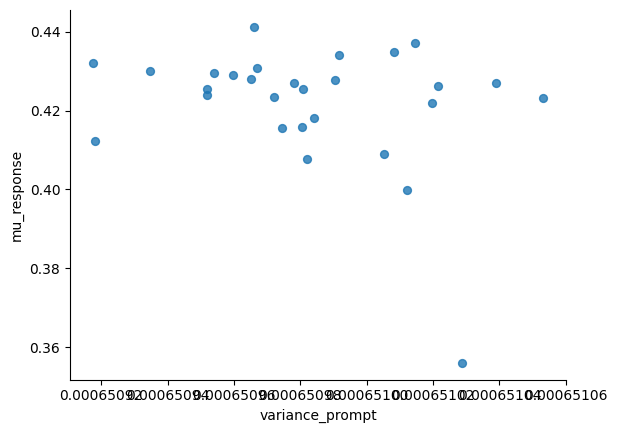

In [ ]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='variance_prompt', y='mu_response', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)